#Global Tech University Admissions Optimizer

This project builds and compares multiple machine learning models to predict the **chance of admission** for graduate applicants based on academic and research credentials. It also includes model interpretation, feature selection, and scholarship eligibility logic.

In [81]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


#### Load & Explore Dataset

In [82]:
# Load dataset
df = pd.read_csv('/content/Admission_Predict.csv')

# Preview
print(df.head())
print(df.info())
print(df.describe())


   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR  CGPA  \
0           1        337          118                  4  4.5  4.5  9.65   
1           2        324          107                  4  4.0  4.5  8.87   
2           3        316          104                  3  3.0  3.5  8.00   
3           4        322          110                  3  3.5  2.5  8.67   
4           5        314          103                  2  2.0  3.0  8.21   

   Research  Chance of Admit  
0         1             0.92  
1         1             0.76  
2         1             0.72  
3         1             0.80  
4         0             0.65  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   Universi

#### Data Cleaning & Preprocessing

In [83]:
# Strip column names to remove trailing spaces
df.columns = df.columns.str.strip()

# Check for missing values
print(df.isnull().sum())

# Drop rows with NA or fill accordingly
df.dropna(inplace=True)

# Encode binary field (e.g., Research)
df['Research'] = df['Research'].astype(int)

# Drop Serial No.
df.drop(columns=['Serial No.'], inplace=True)

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64


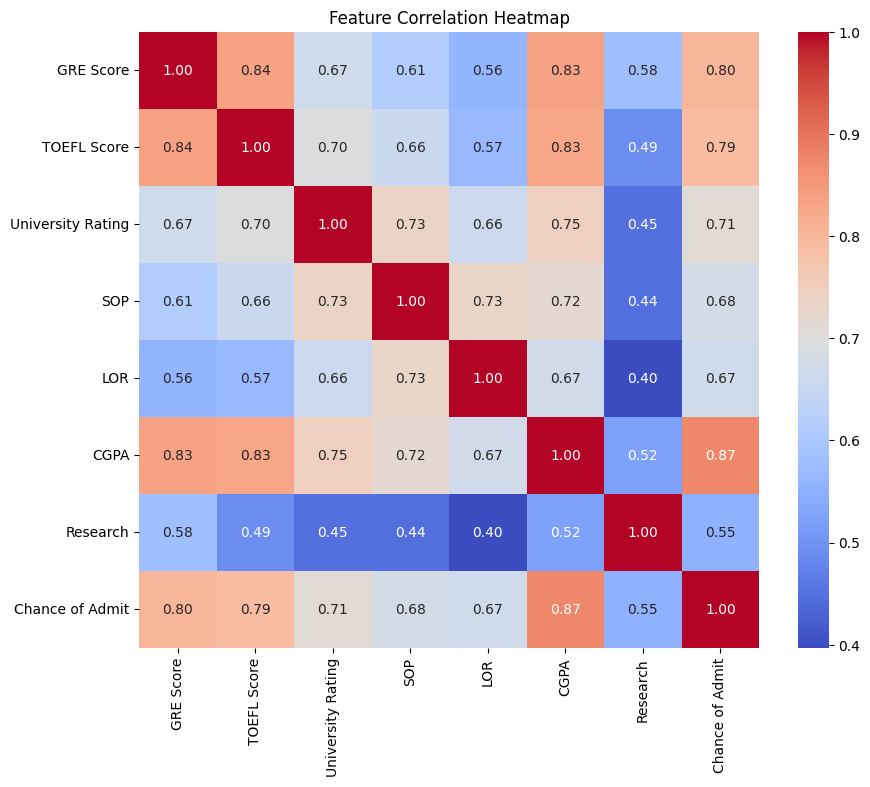

In [84]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [85]:
# Define features and target
X = df.drop(columns=['Chance of Admit'])
y = df['Chance of Admit']

# Save feature names for reuse
feature_names = X.columns.tolist()

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
feature_names = X.columns

#### Baseline Model – Multiple Linear Regression

In [86]:
# Convert scaled features to DataFrame for VIF
X_df = pd.DataFrame(X_scaled, columns=X.columns)

# Handling Multicollinearity with VIF
# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
print(vif_data)

             Feature       VIF
0          GRE Score  4.615516
1        TOEFL Score  4.288959
2  University Rating  2.919606
3                SOP  3.075504
4                LOR  2.431258
5               CGPA  5.207403
6           Research  1.543312


#### Train Linear Regression

In [87]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict & Evaluate
y_pred_lr = linreg.predict(X_test)
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

# Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': linreg.coef_})
print(coef_df.sort_values(by='Coefficient', ascending=False))

Linear Regression R2: 0.8212082591486991
RMSE: 0.06794853476922817
             Feature  Coefficient
5               CGPA     0.068294
0          GRE Score     0.021343
1        TOEFL Score     0.016511
4                LOR     0.014151
6           Research     0.011063
2  University Rating     0.008427
3                SOP    -0.000294


#### What-if Model – Decision Tree Regressor
Tuning and Visualization

Decision Tree R2: 0.7831181464533823


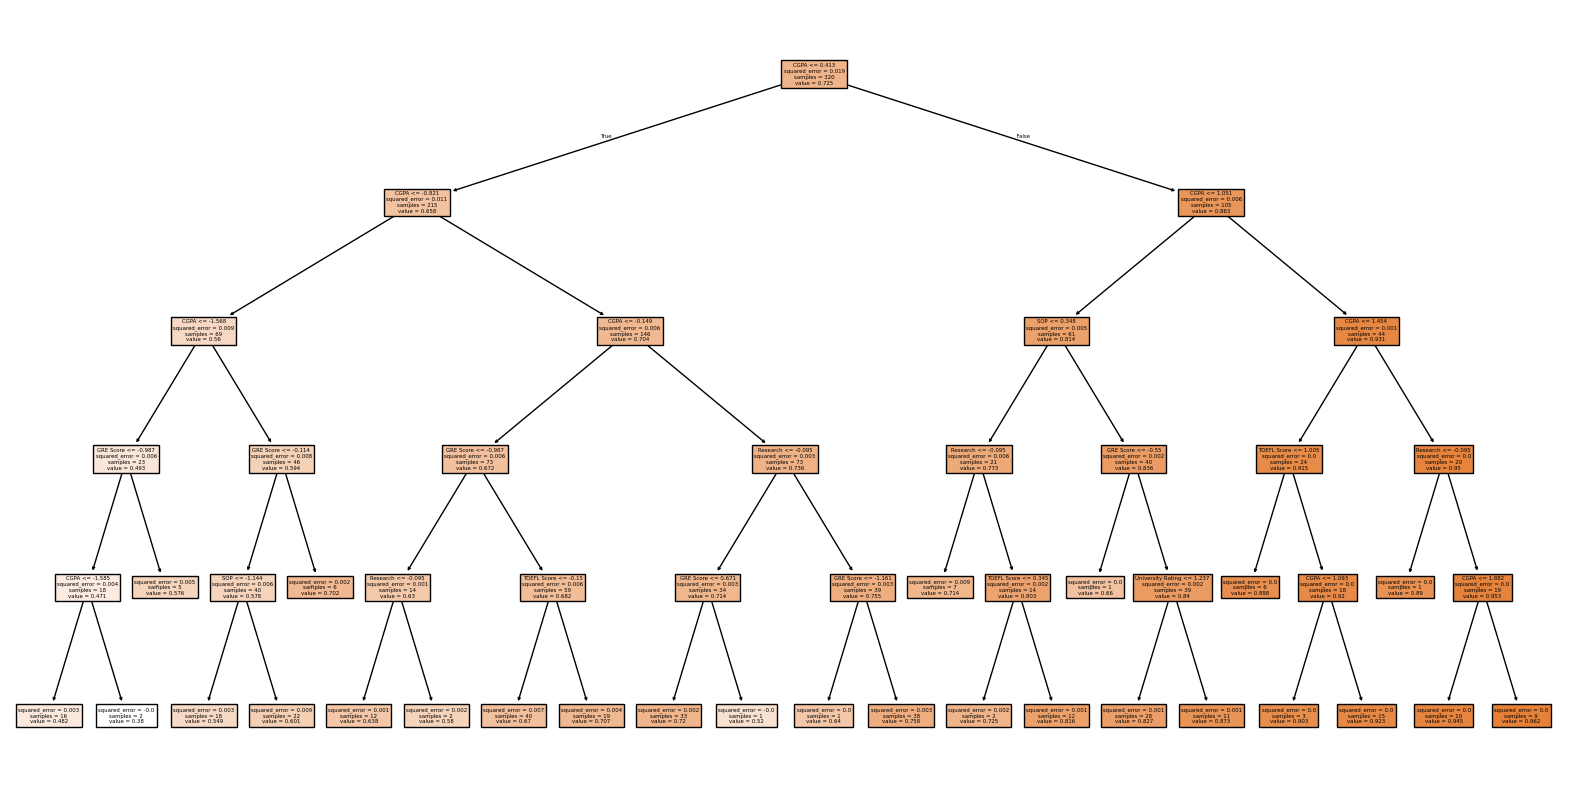

In [96]:
# Decision Tree with basic tuning
dtree = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)
dtree.fit(X_train, y_train)

# Evaluate
y_pred_dt = dtree.predict(X_test)
print("Decision Tree R2:", r2_score(y_test, y_pred_dt))

# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(dtree, feature_names=X.columns, filled=True)
plt.show()

In [97]:
dt = DecisionTreeRegressor(random_state=42)

param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(dt, param_grid=param_grid_dt, cv=5, verbose=2, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

print("Best DT Params:", grid_search_dt.best_params_)

y_pred_dt = grid_search_dt.predict(X_test)
print("Decision Tree R2:", r2_score(y_test, y_pred_dt))
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best DT Params: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Decision Tree R2: 0.7953487357837182
Decision Tree RMSE: 0.07269651396322331


#### Robust Model – Random Forest Regressor
 Randomized Hyperparameter Tuning

Random Forest R2: 0.8079153455793804


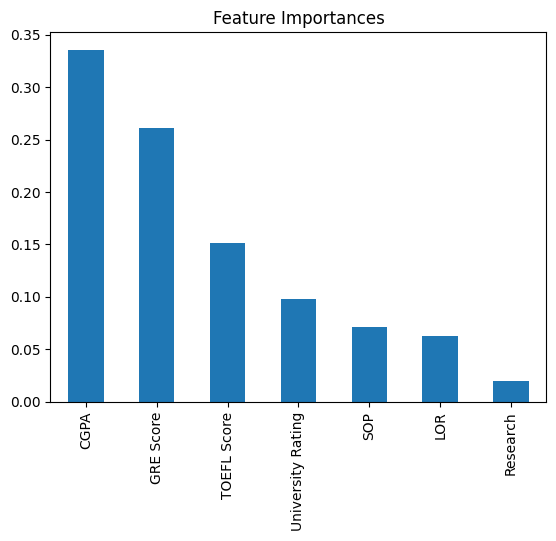

In [90]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.8]
}

# Random Search CV
rf = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(rf, param_grid, n_iter=10, cv=3, random_state=42, scoring='r2')
rf_random.fit(X_train, y_train)

feature_names = X.columns

# Best model
best_rf = rf_random.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

# Feature importances
feat_imp = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_imp.sort_values(ascending=False).plot(kind='bar', title='Feature Importances')
plt.show()

In [102]:
from sklearn.model_selection import GridSearchCV

# Define full parameter grid (smaller than RandomizedSearch to avoid long run time)
param_grid_full = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Instantiate base model
rf = RandomForestRegressor(random_state=42)

# Grid Search CV
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid_full, cv=3, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Evaluate GridSearch model
best_rf_grid = rf_grid.best_estimator_
y_pred_rf_grid = best_rf_grid.predict(X_test)

print("Random Forest (GridSearchCV) R2:", r2_score(y_test, y_pred_rf_grid))
print("Best GridSearchCV Params:", rf_grid.best_params_)

Random Forest (GridSearchCV) R2: 0.8121556829335628
Best GridSearchCV Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}


RandomizedSearchCV was used first for efficiency: it explores a wider parameter space quickly by sampling combinations. It achieved R² = 0.808.

GridSearchCV was used afterward to explore specific promising ranges in more depth. It achieved a slightly better R² = 0.812, suggesting that in this case, exhaustive search slightly outperformed random search, though with higher compute time.

#### Feature Selection-Based Modeling

In [91]:
# Select top 5 important features
top_features = feat_imp.sort_values(ascending=False).head(5).index.tolist()
print("Top 5 Features:", top_features)

# Recreate datasets
X_top = df[top_features]
# Use a separate scaler so original is preserved
top_scaler = StandardScaler()
X_top_scaled = top_scaler.fit_transform(X_top)
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(X_top_scaled, y, test_size=0.2, random_state=42)

# Retrain models on top features
rf_top = RandomForestRegressor(random_state=42)
rf_top.fit(X_train_top, y_train_top)
print("Top Features RF R2:", r2_score(y_test_top, rf_top.predict(X_test_top)))


Top 5 Features: ['CGPA', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP']
Top Features RF R2: 0.7844285461019725


In [92]:
top5_features = ['CGPA', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP']

X_top5 = df[top5_features]
X_train_top5, X_test_top5, y_train, y_test = train_test_split(X_top5, y, test_size=0.2, random_state=42)

# Train Linear Regression on top 5
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_top5, y_train)
y_pred_lr = lr.predict(X_test_top5)

print("Linear Regression (top 5) R2:", r2_score(y_test, y_pred_lr))
print("Linear Regression (top 5) RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

# Train tuned Decision Tree on top 5
best_dt = grid_search_dt.best_estimator_
best_dt.fit(X_train_top5, y_train)
y_pred_dt_top5 = best_dt.predict(X_test_top5)

print("Decision Tree (top 5) R2:", r2_score(y_test, y_pred_dt_top5))
print("Decision Tree (top 5) RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt_top5)))

# Train tuned Random Forest on top 5
best_rf = rf_random.best_estimator_
best_rf.fit(X_train_top5, y_train)
y_pred_rf_top5 = best_rf.predict(X_test_top5)

print("Random Forest (top 5) R2:", r2_score(y_test, y_pred_rf_top5))
print("Random Forest (top 5) RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf_top5)))


Linear Regression (top 5) R2: 0.7982791182889645
Linear Regression (top 5) RMSE: 0.0721741700462564
Decision Tree (top 5) R2: 0.7777492801778397
Decision Tree (top 5) RMSE: 0.07575790525958383
Random Forest (top 5) R2: 0.7942884187675254
Random Forest (top 5) RMSE: 0.07288459432394266


We observe simplified models with minimal accuracy loss using top 05 features; slightly reduced R² but improved generalization and interpretability. Ideal for deployment scenarios.

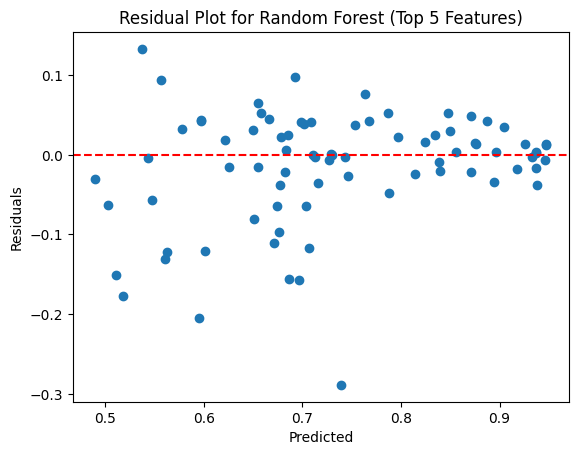

In [99]:
# Residual plot for top RF
residuals = y_test - y_pred_rf_top5
plt.scatter(y_pred_rf_top5, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot for Random Forest (Top 5 Features)")
plt.show()

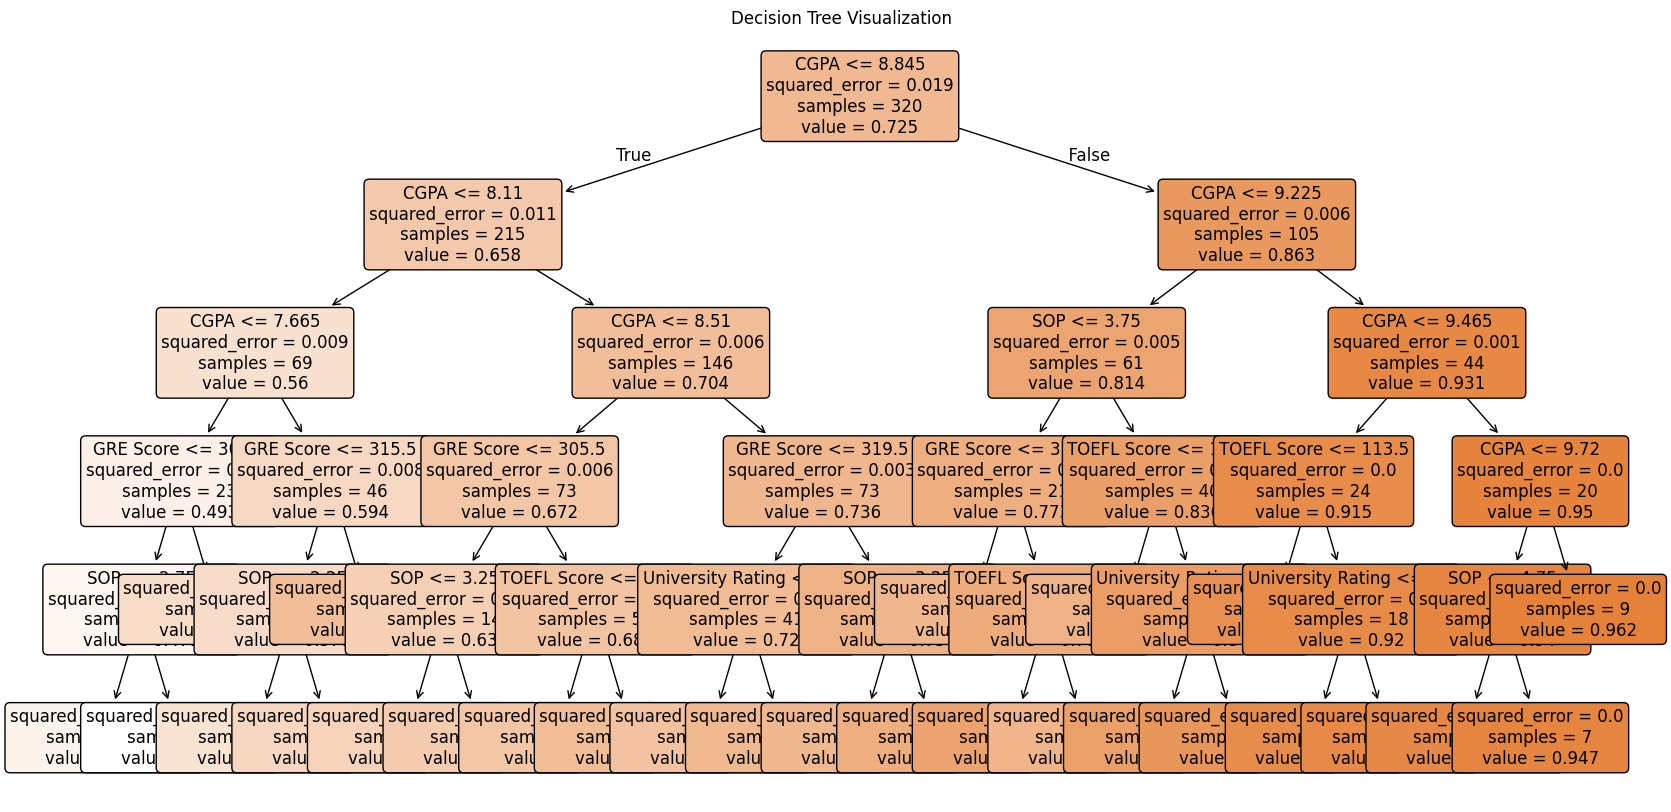

In [98]:
# Decision Tree visualization (best tuned tree)
plt.figure(figsize=(20,10))
plot_tree(best_dt, feature_names=top5_features, filled=True, rounded=True, fontsize=12)
plt.title("Decision Tree Visualization")
plt.show()

#### Demo-Day Simulation

In [70]:
# Demo-day example
demo = pd.DataFrame({
    'GRE Score': [322],
    'TOEFL Score': [111],
    'University Rating': [3],
    'SOP': [4.5],
    'LOR': [4.5],
    'CGPA': [8.9],
    'Research': [1]
})

# Ensure columns match training
demo = demo[feature_names]

# Scale demo with original scaler
demo_scaled = scaler.transform(demo)

# Predict with best model
admit_prob = best_rf.predict(demo_scaled)[0]
print(f"🎓 Demo Admit Probability: {admit_prob * 100:.2f}%")

# Scholarship Rule
if admit_prob > 0.8 and demo['Research'].iloc[0] == 1 and demo['CGPA'].iloc[0] > 8.5:
    print("✅ Scholarship Recommended")
else:
    print("❌ No Scholarship")

🎓 Demo Admit Probability: 79.59%
❌ No Scholarship
